# Insiders Clustering Project

# 0.0 General Area

## 0.1 Imports

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import inflection
import warnings
import re

from matplotlib import pyplot        as plt
from sklearn    import cluster       as c
from sklearn    import metrics       as m
from sklearn    import preprocessing as pp
from plotly     import express       as px

from ydata_profiling     import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


import umap.umap_ as umap

## 0.2 Support Functions

In [3]:
# data description functions
def numerical_attributes( df ):
    df_num_attributes = df.select_dtypes( include=['int64', 'float64'] )

    # Central Tendency - mean, median
    df_mean   = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
    df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T
    
    # Dispersion - min, max, range, std, skew, kurtosis
    df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
    df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
    df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
    df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
    df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
    df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T
    
    # concatenate dataframes
    df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
    df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
    df_numerical
    
    return df_numerical

def categorical_attributes( df ):
    df_categorical = df.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

    return df_categorical

# data cleaning functions
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    df = df.rename( columns = {'customer' : 'customer_id' } )

    return df

# feature engineering functions
def feature_creation( df ):
    # creating gross revenue
    df['gross_revenue'] = df['quantity'] * df['unit_price']    
    
    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    #display( HTML( '<style>.container { width:100% !important; }</style>') )

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()
warnings.filterwarnings( 'ignore' )

## 0.3 Load Data

In [4]:
df_raw = pd.read_csv( '../data/Ecommerce.csv', low_memory=False, encoding='latin1')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [6]:
print(f'Number of rows: { df1.shape[0] } ')
print(f'Number of cols: { df1.shape[1] } ')

Number of rows: 541909 
Number of cols: 9 


## 1.2 List Data Types

In [7]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Unnamed: 8     float64
dtype: object

## 1.3 Descriptive Statistics

In [8]:
# identify and separate numerical and categorical attrributes
df_numerical   = numerical_attributes( df1 )
df_categorical = categorical_attributes( df1 )

### 1.3.1 Numerical Attributes

In [9]:
df_numerical.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,UnitPrice,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,CustomerID,12346.00,18287.0,5941.00,15287.690570,NaN,1713.598197,0.029835,-1.179982
3,Unnamed: 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.2 Categorical Attributes

In [10]:
df_categorical.head()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,29-Nov-16,United Kingdom
1,536365,71053,WHITE METAL LANTERN,29-Nov-16,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,29-Nov-16,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,29-Nov-16,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,29-Nov-16,United Kingdom


# 2.0 Data Cleaning

In [11]:
df2 = df1.copy()

## 2.1 Rename Columns

In [12]:
df2 = rename_columns( df2 )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,unnamed:8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


## 2.2 Drop Columns

In [13]:
df2 = df2.drop( 'unnamed:8', axis=1 )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 2.3 Check N/A

In [14]:
# number of rows with NA values by column
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Unnamed: 8     541909
dtype: int64

## 2.4 Fillout N/A

### customer_id

In [15]:
#df2['customer_id'].max() = 1828

df_missing = df2[df2['customer_id'].isna()]
df_missing = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_missing['customer_id'] = np.arange( 1900, 1900+len( df_missing ), 1 )

df_missing.head()

,invoice_no,customer_id
622,536414,1900
1443,536544,1901
1970,536545,1902
1971,536546,1903
1972,536547,1904


In [16]:
# merging with missing customer_id dataframe
df2 = pd.merge( df2, df_missing, how='left', on='invoice_no' )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id_x,country,customer_id_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [17]:
# apply coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first( df2['customer_id_y'] )

# drop extra columns
df2 =df2.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [18]:
# re-check n/a values
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 2.5 Drop N/A Values

In [19]:
df2 = df2.dropna( subset = ['description', 'customer_id'] )

print(f'Removed data : { round( 1 - ( df2.shape[0] / df_raw.shape[0] ), 2) } ') 
print(f'Number of rows Updated: { df2.shape[0] } ')

Removed data : 0.0 
Number of rows Updated: 540455 


## 2.6 Change Data Types

In [20]:
df2['invoice_date'] = pd.to_datetime( df2['invoice_date'] )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850.0


## 2.7 Remove Rows

### invoice_no

In [21]:
# identify invoice_no with letters
index = df2['invoice_no'].apply( lambda x : bool( re.search( '[^0-9]+', x ) ) )
df_letter_invoices =  df2.loc[ index, :] 
df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548.0


### stock_code

In [22]:
# identify stock_code with only letters
index = df2['stock_code'].apply( lambda x : bool( re.search( '^[a-zA-Z]+$', x ) ) )
df_letter_stock_code = df2.loc[ index, :] 

list_stock_code = df_letter_stock_code['stock_code'].unique()
print(f'Rows removed: { len( df2[ df2["stock_code"].isin( list_stock_code ) ] ) } ' )

df2 = df2[ ~df2['stock_code'].isin( list_stock_code ) ]

Rows removed: 2754 


In [23]:
list_stock_code = df_letter_stock_code['stock_code'].unique()
print(f'Rows removed: { len( df2[ df2["stock_code"].isin( list_stock_code ) ] ) } ' )

df2 = df2[ ~df2['stock_code'].isin( list_stock_code ) ]

Rows removed: 0 


### unit_price

In [24]:
# removing rows when unit_price < 0.04
print(f'Rows removed: { len( df2[ df2["unit_price"] < 0.04] ) } ' )
df2 = df2[ df2['unit_price'] >= 0.04]

Rows removed: 1054 


### country

In [25]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [26]:
# removing rows where are no contries
print(f'Rows removed: { len( df2[ df2["country"].isin( ["European Community", "Unspecified"] ) ] ) } ' )
df2 = df2[ ~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

Rows removed: 504 


## 2.8 Separate original dataset in two: purchases and returns

In [27]:
df_returns   = df2[ df2['quantity'] < 0]
df_purchases = df2[ df2['quantity'] > 0]

# 3.0 Feature Engineering

In [28]:
df3 = df_purchases.copy()

## 3.1 Feature Creation

In [29]:
def feature_creation( df, df_returns ):
    # creating gross revenue
    df['gross_revenue'] = df['quantity'] * df['unit_price']    

    # creating customer dataframe
    df_customer = df.drop( columns= ['invoice_no', 'stock_code', 'description', 'quantity', 
                                      'invoice_date', 'unit_price', 'country', 'gross_revenue'], axis=1).drop_duplicates( ignore_index=True )

    # creating customer monetary dataframe - amount of purchases
    df_monetary = df[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

    # creating customer frequency dataframe - number of purchases
    df_frequency = df[['customer_id', 'invoice_no']].groupby('customer_id').nunique().reset_index()

    # creating customer recency dataframe - number of days since last purchase
    max_invoice_date = df['invoice_date'].max()

    df_recency = df[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
    df_recency['recency_days'] =  ( max_invoice_date - df_recency['invoice_date'] ).dt.days
    df_recency = df_recency.drop( 'invoice_date', axis=1 )

    # creating average customer ticket dataframe
    df_avg_ticket = ( df[['customer_id', 'gross_revenue']]
                        .groupby('customer_id')
                        .mean()
                        .reset_index()
                        .rename( columns={ 'gross_revenue' : 'avg_ticket' } ) )

    # creating quantity products purchased dataframe
    df_prod_purchased = ( df[['customer_id', 'quantity']]
                         .groupby('customer_id')
                         .count()
                         .reset_index()
                         .rename( columns= {'quantity' : 'qtt_prod_purchased' } ) )

    # creating purchase frequency dataframe = qtt_purchases / range_days
    df_aux = ( df[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                .groupby( 'customer_id' )
                                                                .agg( max_ =  ( 'invoice_date', 'max' ),
                                                                      min_ =  ( 'invoice_date', 'min' ),
                                                                      days_ = ( 'invoice_date', lambda x : ( x.max() - x.min() ).days + 1),
                                                                      buys_ = ( 'invoice_no', 'count' ) ) ).reset_index()
    # calculate purchase frequency 
    df_aux['purchase_frequency'] = df_aux[['buys_', 'days_']].apply( lambda x : x['buys_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )
    df_purc_freq = df_aux[['customer_id', 'purchase_frequency']]

    # number of returns
    df_returns = df_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={ 'quantity' : 'qtt_returns' } )
    df_returns['qtt_returns'] = abs( df_returns['qtt_returns'] )

    # basket size - quantity
    df_bsize_quantity = ( df_purchases[['customer_id', 'invoice_no', 'quantity']]
                                .groupby('customer_id')
                                .agg( n_purchases=( 'invoice_no', 'nunique' ),
                                      n_products=( 'quantity', 'sum' ) )
                                .reset_index() )

    df_bsize_quantity['avg_bsize_quantity'] = df_bsize_quantity['n_products'] / df_bsize_quantity['n_purchases'] 
    df_bsize_quantity = df_bsize_quantity.drop( columns=['n_products', 'n_purchases'], axis=1 )

    # basket size - variety
    df_bsize_variety = ( df_purchases[['customer_id', 'invoice_no', 'stock_code']]
                                    .groupby('customer_id')
                                    .agg( n_purchases=( 'invoice_no', 'nunique' ),
                                          n_products=( 'stock_code', 'nunique' ) )
                                    .reset_index() )
    
    df_bsize_variety['avg_bsize_variety'] = df_bsize_variety['n_products'] / df_bsize_variety['n_purchases'] 
    df_bsize_variety = df_bsize_variety.drop( columns=['n_products', 'n_purchases'], axis=1)

    # merging customer dataframes
    df_customer = pd.merge( df_customer, df_recency,         how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_frequency,       how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_monetary,        how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_avg_ticket,      how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_prod_purchased,  how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_purc_freq,       how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_returns,         how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_bsize_quantity,  how='left', on='customer_id' )
    df_customer = pd.merge( df_customer, df_bsize_variety,   how='left', on='customer_id' )

    df_customer.loc[ df_customer['qtt_returns'].isna(), 'qtt_returns'] = 0

    return df_customer
    

In [30]:
df3 = feature_creation( df3, df_returns )
df3.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,qtt_prod_purchased,purchase_frequency,qtt_returns,avg_bsize_quantity,avg_bsize_variety
0,17850.0,372,34,5391.21,18.152222,297,17.000000,40.0,50.970588,0.617647
1,13047.0,56,9,3232.59,18.904035,171,0.028302,35.0,154.444444,11.666667
2,12583.0,2,15,6705.38,28.902500,232,0.040323,50.0,335.200000,7.600000
3,13748.0,95,5,948.25,33.866071,28,0.017921,0.0,87.800000,4.800000
4,15100.0,333,3,876.00,292.000000,3,0.073171,22.0,26.666667,0.333333


In [31]:
df3.isna().sum()

customer_id           0
recency_days          0
invoice_no            0
gross_revenue         0
avg_ticket            0
qtt_prod_purchased    0
purchase_frequency    0
qtt_returns           0
avg_bsize_quantity    0
avg_bsize_variety     0
dtype: int64

In [32]:
# average recency days
df2 = df_purchases.copy()
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id']  = df_aux['customer_id'].shift()
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift()
df_aux['avg_recency_days']  = df_aux.apply( lambda x : ( x['next_invoice_date'] - x['invoice_date'] ).days if x['customer_id'] == x['next_customer_id'] 
                                            else np.nan, axis=1 )

df_aux.head(10)


,customer_id,invoice_date,next_customer_id,next_invoice_date,avg_recency_days
423939,18287.0,2017-10-26,NaN,NaT,NaN
392716,18287.0,2017-10-10,18287.0,2017-10-26,16.0
198716,18287.0,2017-05-20,18287.0,2017-10-10,143.0
530454,18283.0,2017-12-04,18287.0,2017-05-20,NaN
514067,18283.0,2017-11-28,18283.0,2017-12-04,6.0
494085,18283.0,2017-11-21,18283.0,2017-11-28,7.0
456033,18283.0,2017-11-08,18283.0,2017-11-21,13.0
422473,18283.0,2017-10-25,18283.0,2017-11-08,14.0
326590,18283.0,2017-09-03,18283.0,2017-10-25,52.0
263633,18283.0,2017-07-12,18283.0,2017-09-03,53.0


# 4.0 Exploratory Data Analysis

In [33]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [33]:
profile = ProfileReport(df4, title="Profiling Report")
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,qtt_prod_purchased,purchase_frequency,qtt_returns,avg_bsize_quantity,avg_bsize_variety
951,14646.0,1,72,279138.02,135.503893,2060,0.203390,288.0,2733.944444,9.708333
462,18102.0,0,60,259657.30,602.453132,431,0.163043,0.0,1068.733333,2.500000
405,17450.0,8,46,194550.79,577.302047,337,0.127778,952.0,1521.586957,2.695652
3263,16446.0,0,2,168472.50,56157.500000,3,0.009709,80995.0,40498.500000,1.500000
65,14911.0,1,199,140450.72,24.757751,5673,0.533512,3332.0,403.331658,8.974874


In [35]:
np.sum( df_purchases.loc[ df_purchases['customer_id'] == 14646.0, 'quantity'] * df_purchases.loc[ df_purchases['customer_id'] == 14646.0, 'unit_price'] )

279138.02

In [36]:
df_purchases.loc[ df_purchases['customer_id'] == 14646.0, 'invoice_no'].nunique()

72

In [37]:
df_purchases.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850.0


## 4.2 Bivariate Analysis

In [ ]:
df4_aux = df4.drop( ['customer_id'], axis=1 )

plt.figure( figsize=(25,12) )
sns.pairplot( df4_aux )

# 5.0 Data Preparation

In [39]:
df5 = df4.copy()

## 5.1 Standard Scaler

In [40]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days']  = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no']    = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket']    = ss.fit_transform( df5[['avg_ticket']] )

# 6.0 Feature Selection

In [41]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning

In [42]:
df7 = df6.copy()

X = df7.drop( columns='customer_id' )
X.head()


,recency_days,invoice_no,gross_revenue,avg_ticket,qtt_prod_purchased,purchase_frequency,qtt_returns,avg_bsize_quantity,avg_bsize_variety
0,2.285010,4.481562,0.454360,-0.028444,297,17.000000,40.0,50.970588,0.617647
1,-0.545579,0.811636,0.180979,-0.027857,171,0.028302,35.0,154.444444,11.666667
2,-1.029288,1.692418,0.620794,-0.020054,232,0.040323,50.0,335.200000,7.600000
3,-0.196234,0.224448,-0.108323,-0.016180,28,0.017921,0.0,87.800000,4.800000
4,1.935665,-0.069146,-0.117473,0.185277,3,0.073171,22.0,26.666667,0.333333


## 7.1 Within-Cluster Sum of Square (WSS)

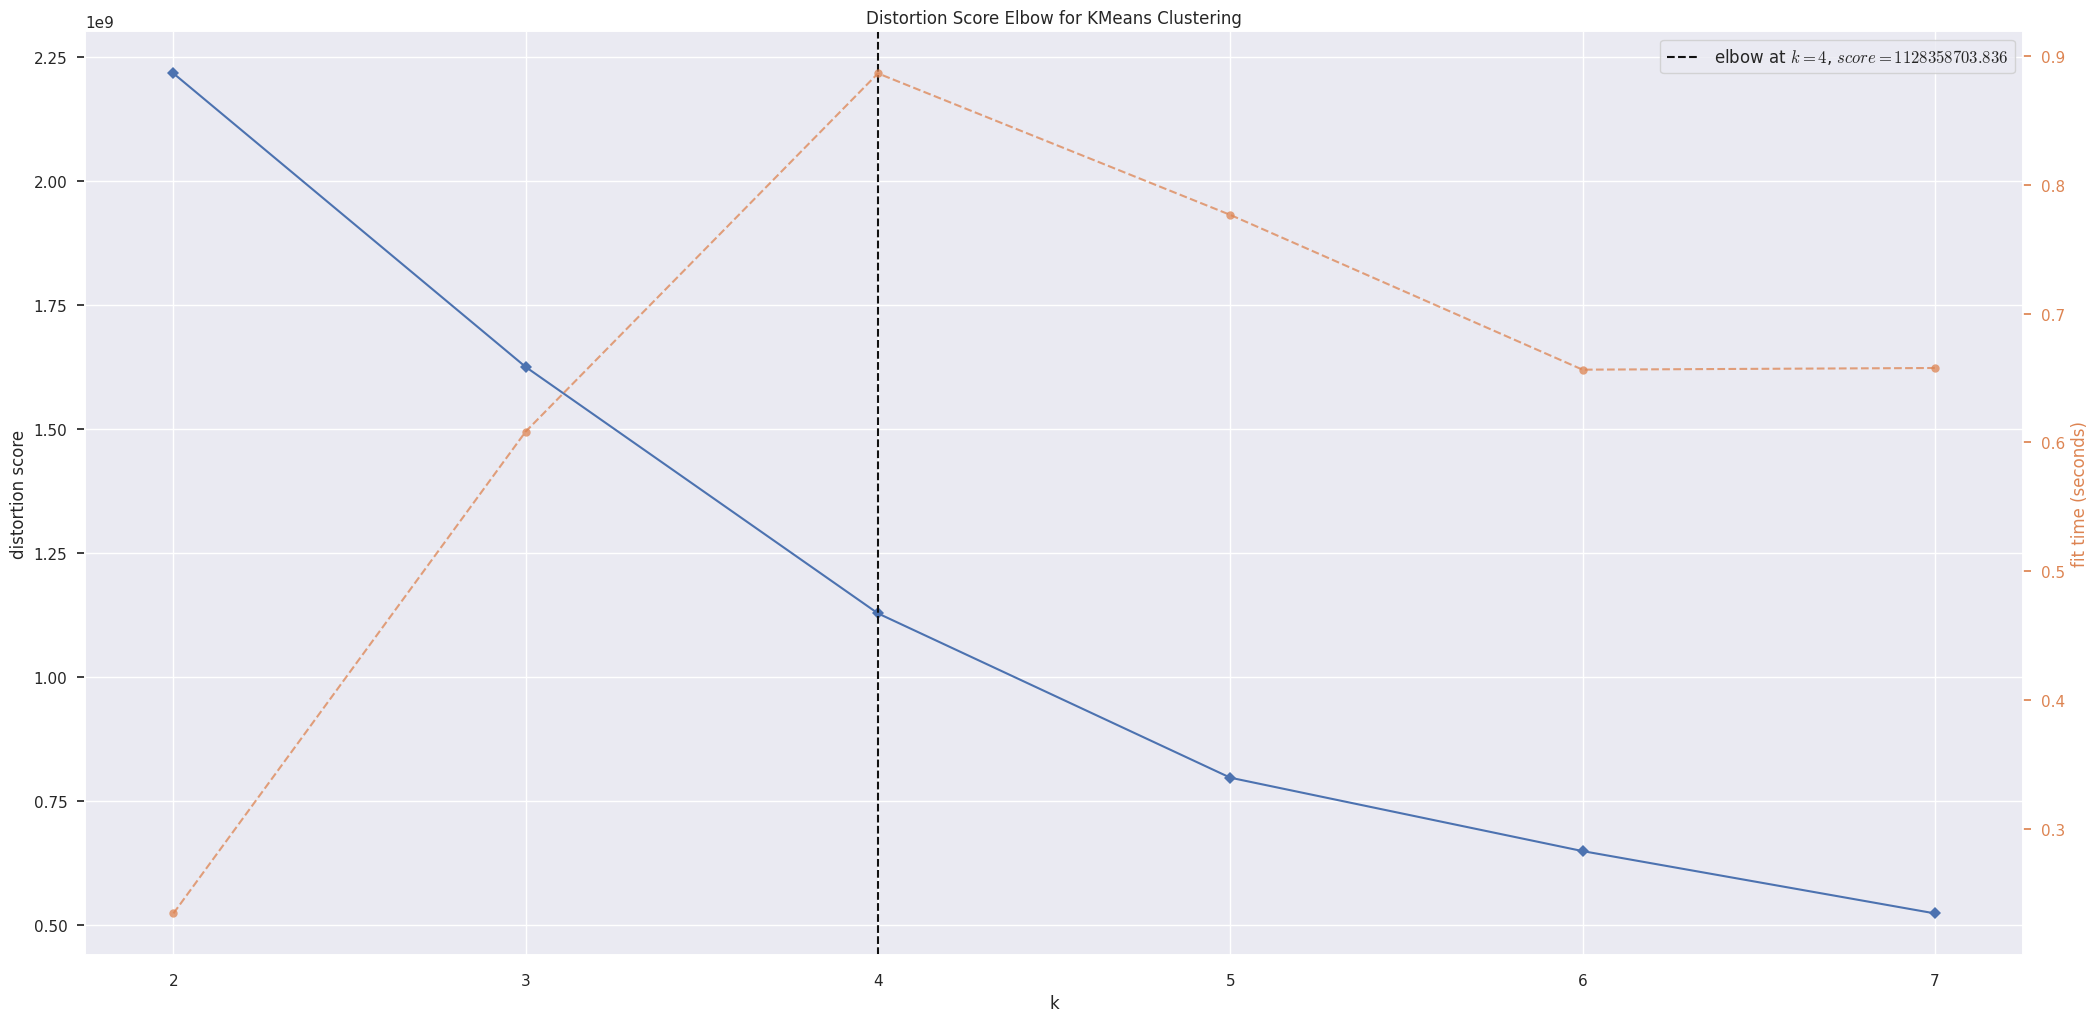

In [43]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timing=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Score

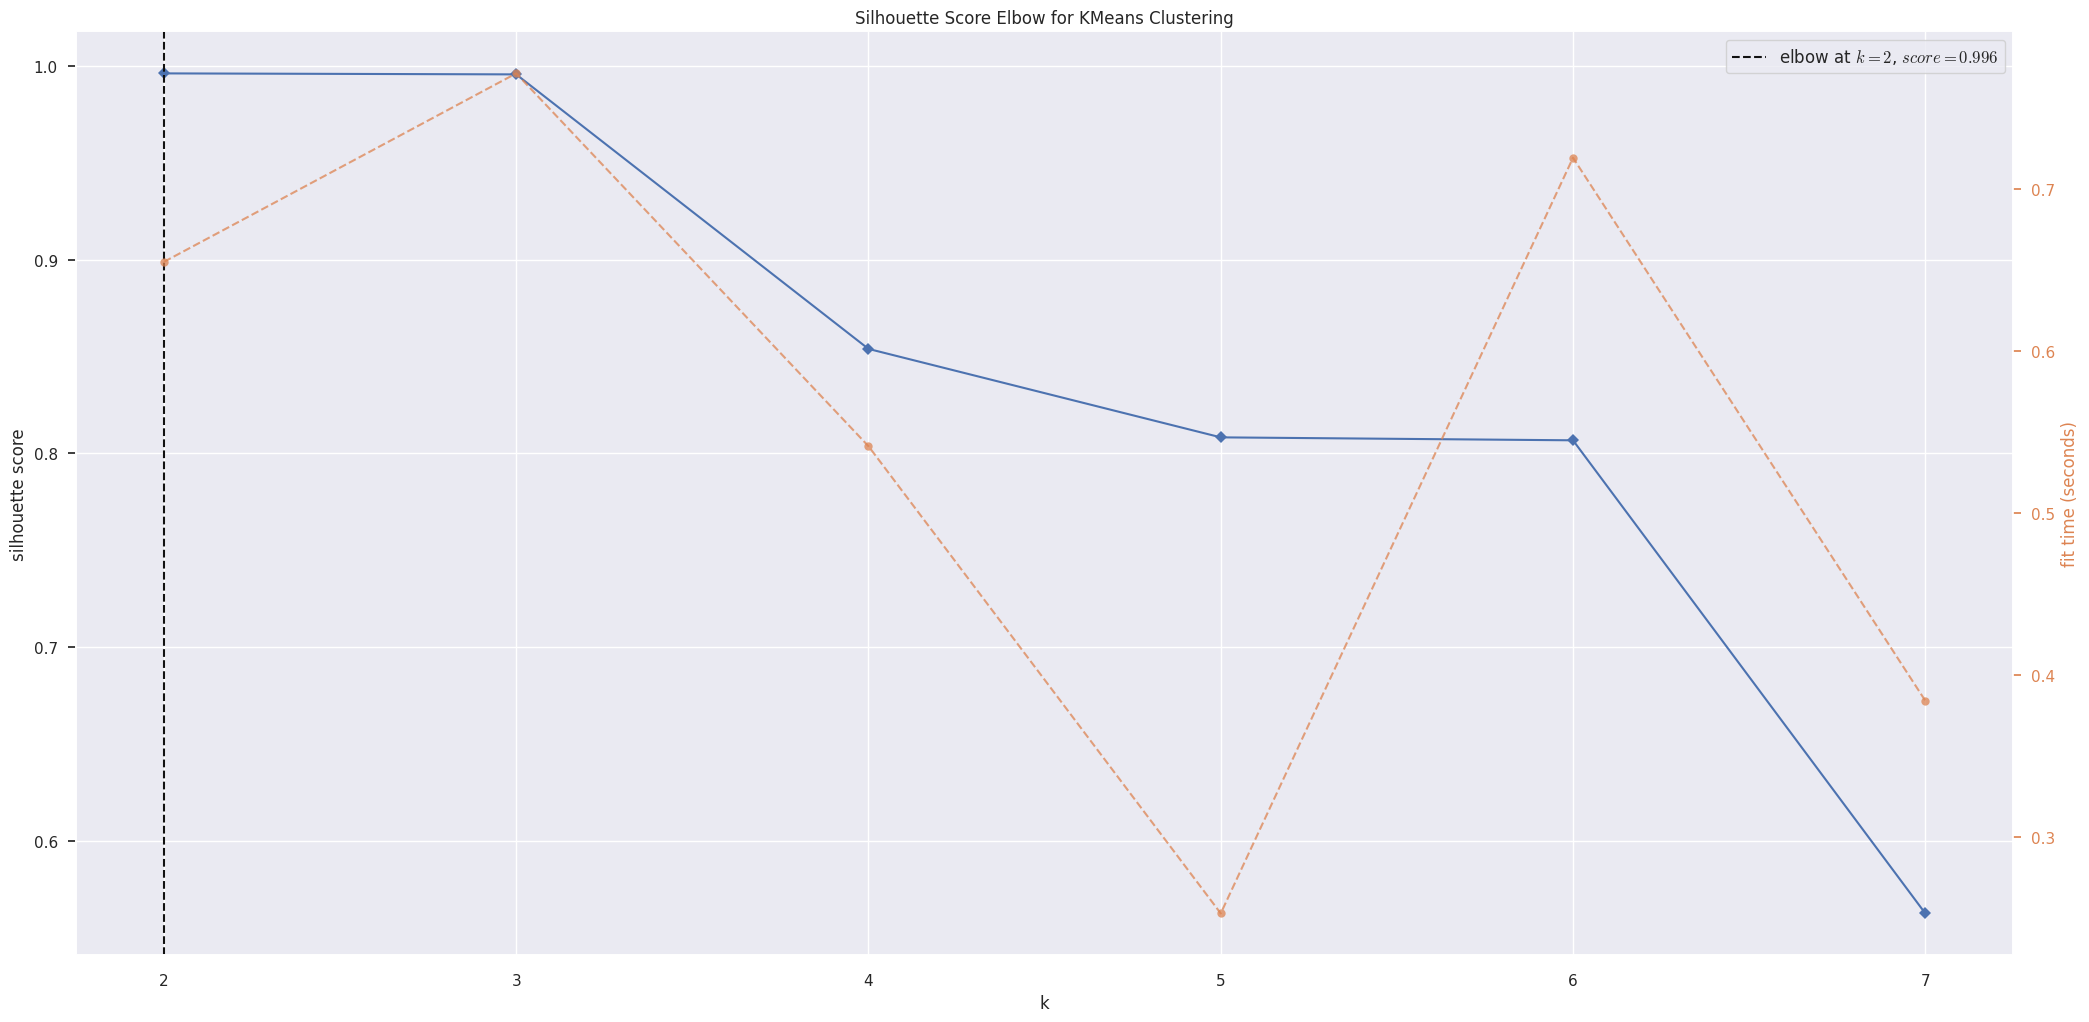

In [44]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timing=False )
kmeans.fit( X )
kmeans.show();

## 7.3 Silhouette Analysis

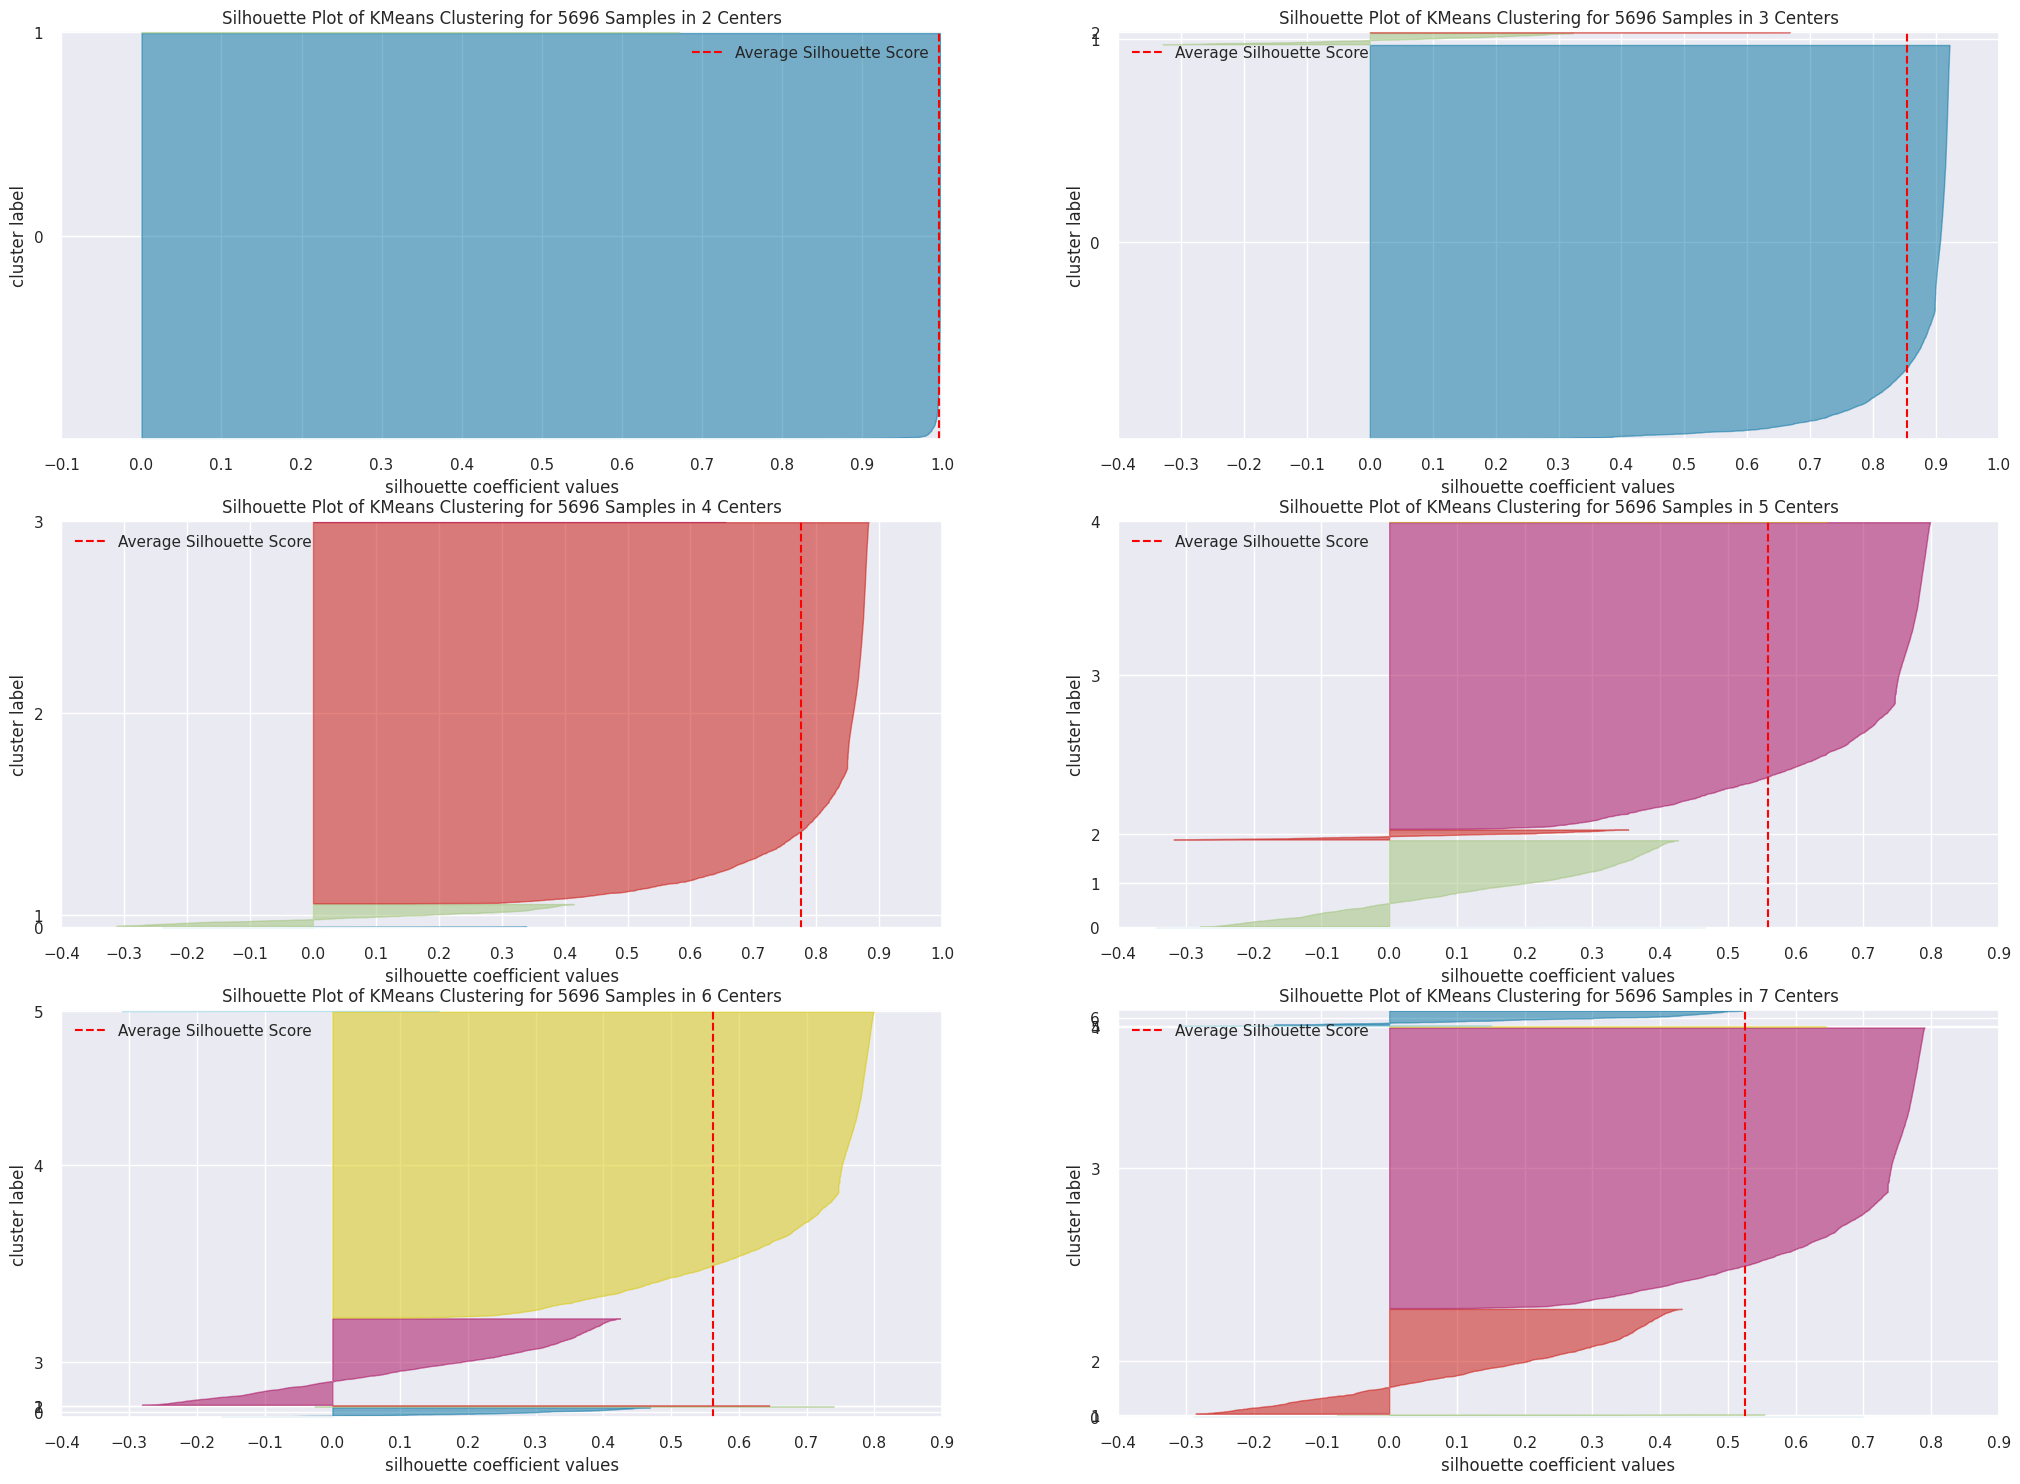

In [45]:
clusters = [2, 3, 4, 5, 6, 7]
fig, axes = plt.subplots(3, 2, figsize=(25, 18) )

for k in clusters:
    q, mod = divmod(k, 2)
    
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42 )
    visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick', ax=axes[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model Training

In [46]:
df8 = df7.copy()

## 8.1 K-Means

In [47]:
# model definition
k=5
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model traning
kmeans.fit( X )

# clustering
labels = kmeans.labels_


## 8.2 Cluster Validation

In [48]:
# WSS - Within Cluster Sum of Square
print(f'WSS : { kmeans.inertia_ } ' )

## SS - Silhouette Score
print(f'SS : { m.silhouette_score( X, labels, metric="euclidean" ) } ' )

WSS : 1264377805.4896727 
SS : 0.5587146880279862 


# 9.0 Cluster Analysis

In [49]:
df9 = df8.copy()

df9['cluster'] = labels
df9.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,qtt_prod_purchased,purchase_frequency,qtt_returns,avg_bsize_quantity,avg_bsize_variety,cluster
0,17850.0,2.285010,4.481562,0.454360,-0.028444,297,17.000000,40.0,50.970588,0.617647,3
1,13047.0,-0.545579,0.811636,0.180979,-0.027857,171,0.028302,35.0,154.444444,11.666667,3
2,12583.0,-1.029288,1.692418,0.620794,-0.020054,232,0.040323,50.0,335.200000,7.600000,1
3,13748.0,-0.196234,0.224448,-0.108323,-0.016180,28,0.017921,0.0,87.800000,4.800000,3
4,15100.0,1.935665,-0.069146,-0.117473,0.185277,3,0.073171,22.0,26.666667,0.333333,3


## 9.1 Visualization Inspection

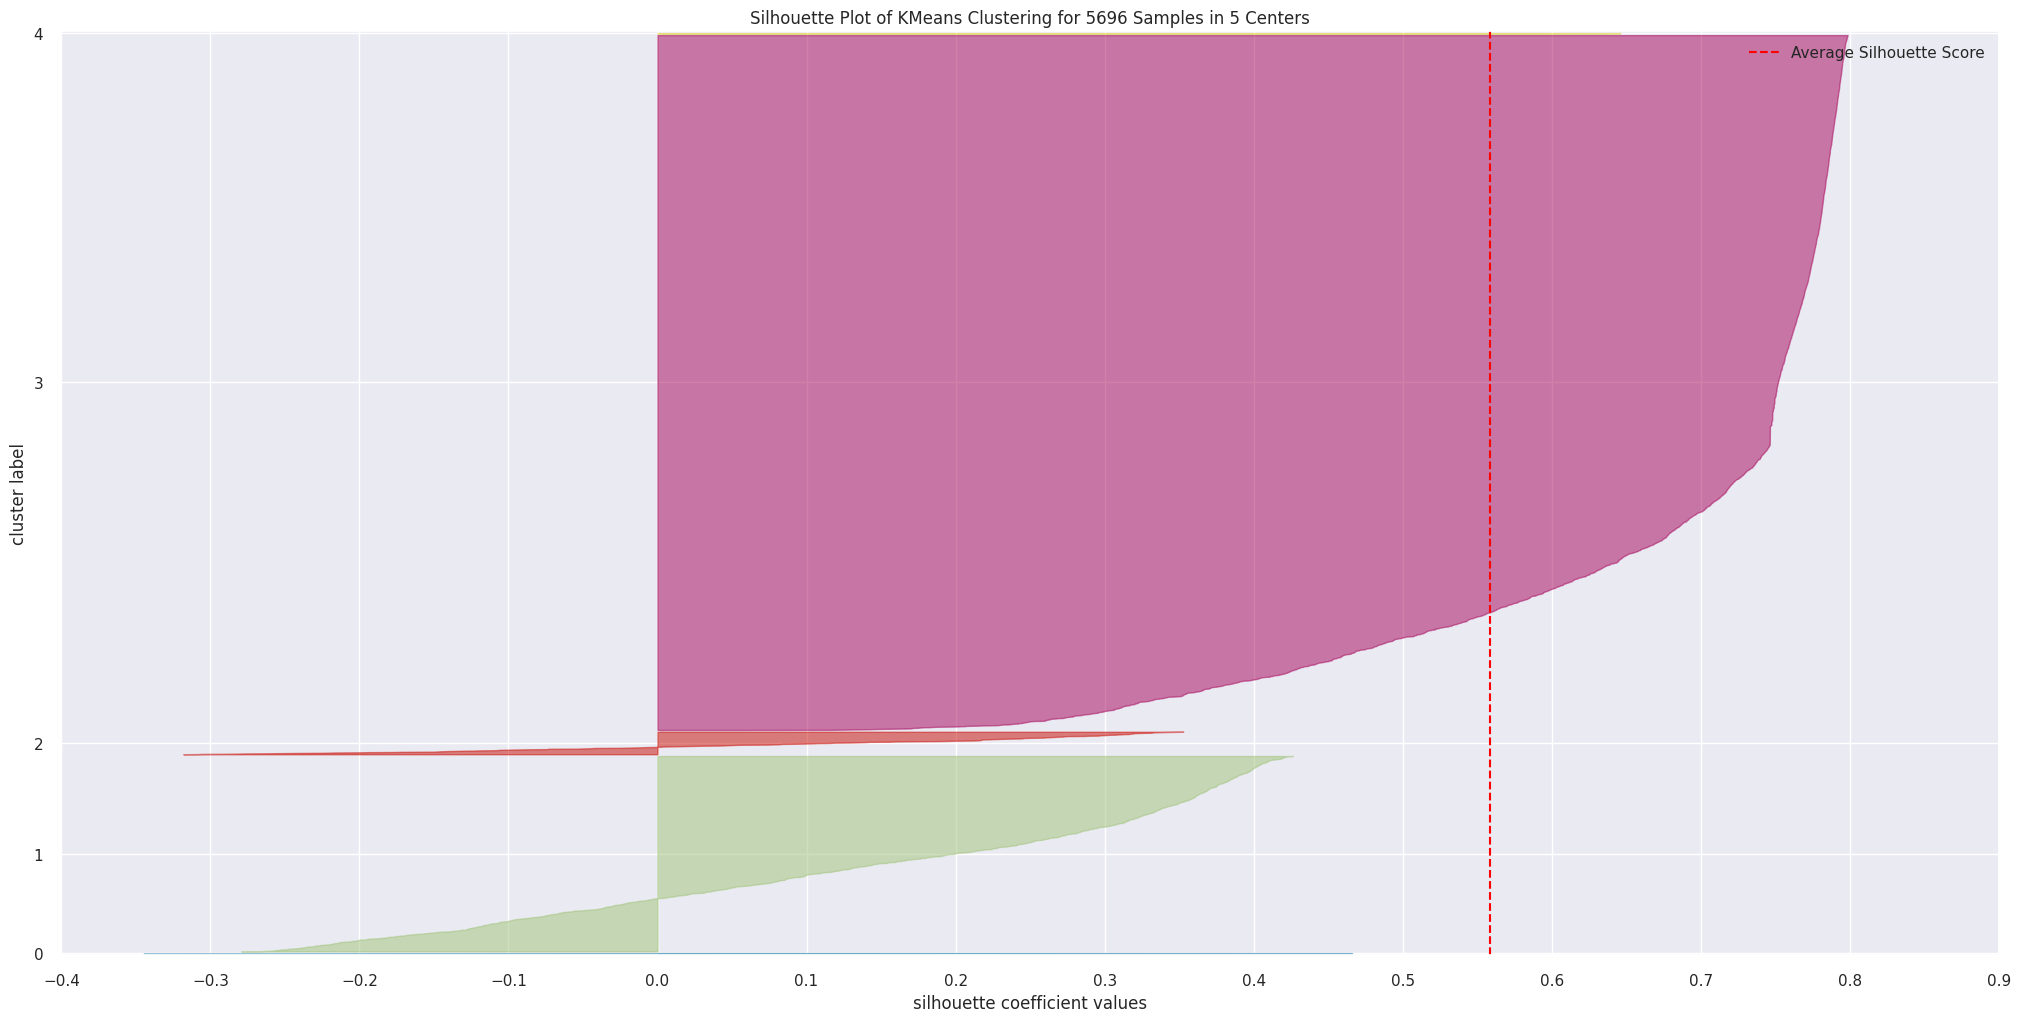

In [50]:
#fig = px.scatter_3d( df10, x='recency_days', y='purchase_frequency', z='gross_revenue', color='cluster' )
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors = 'yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 9.2 2D Plot

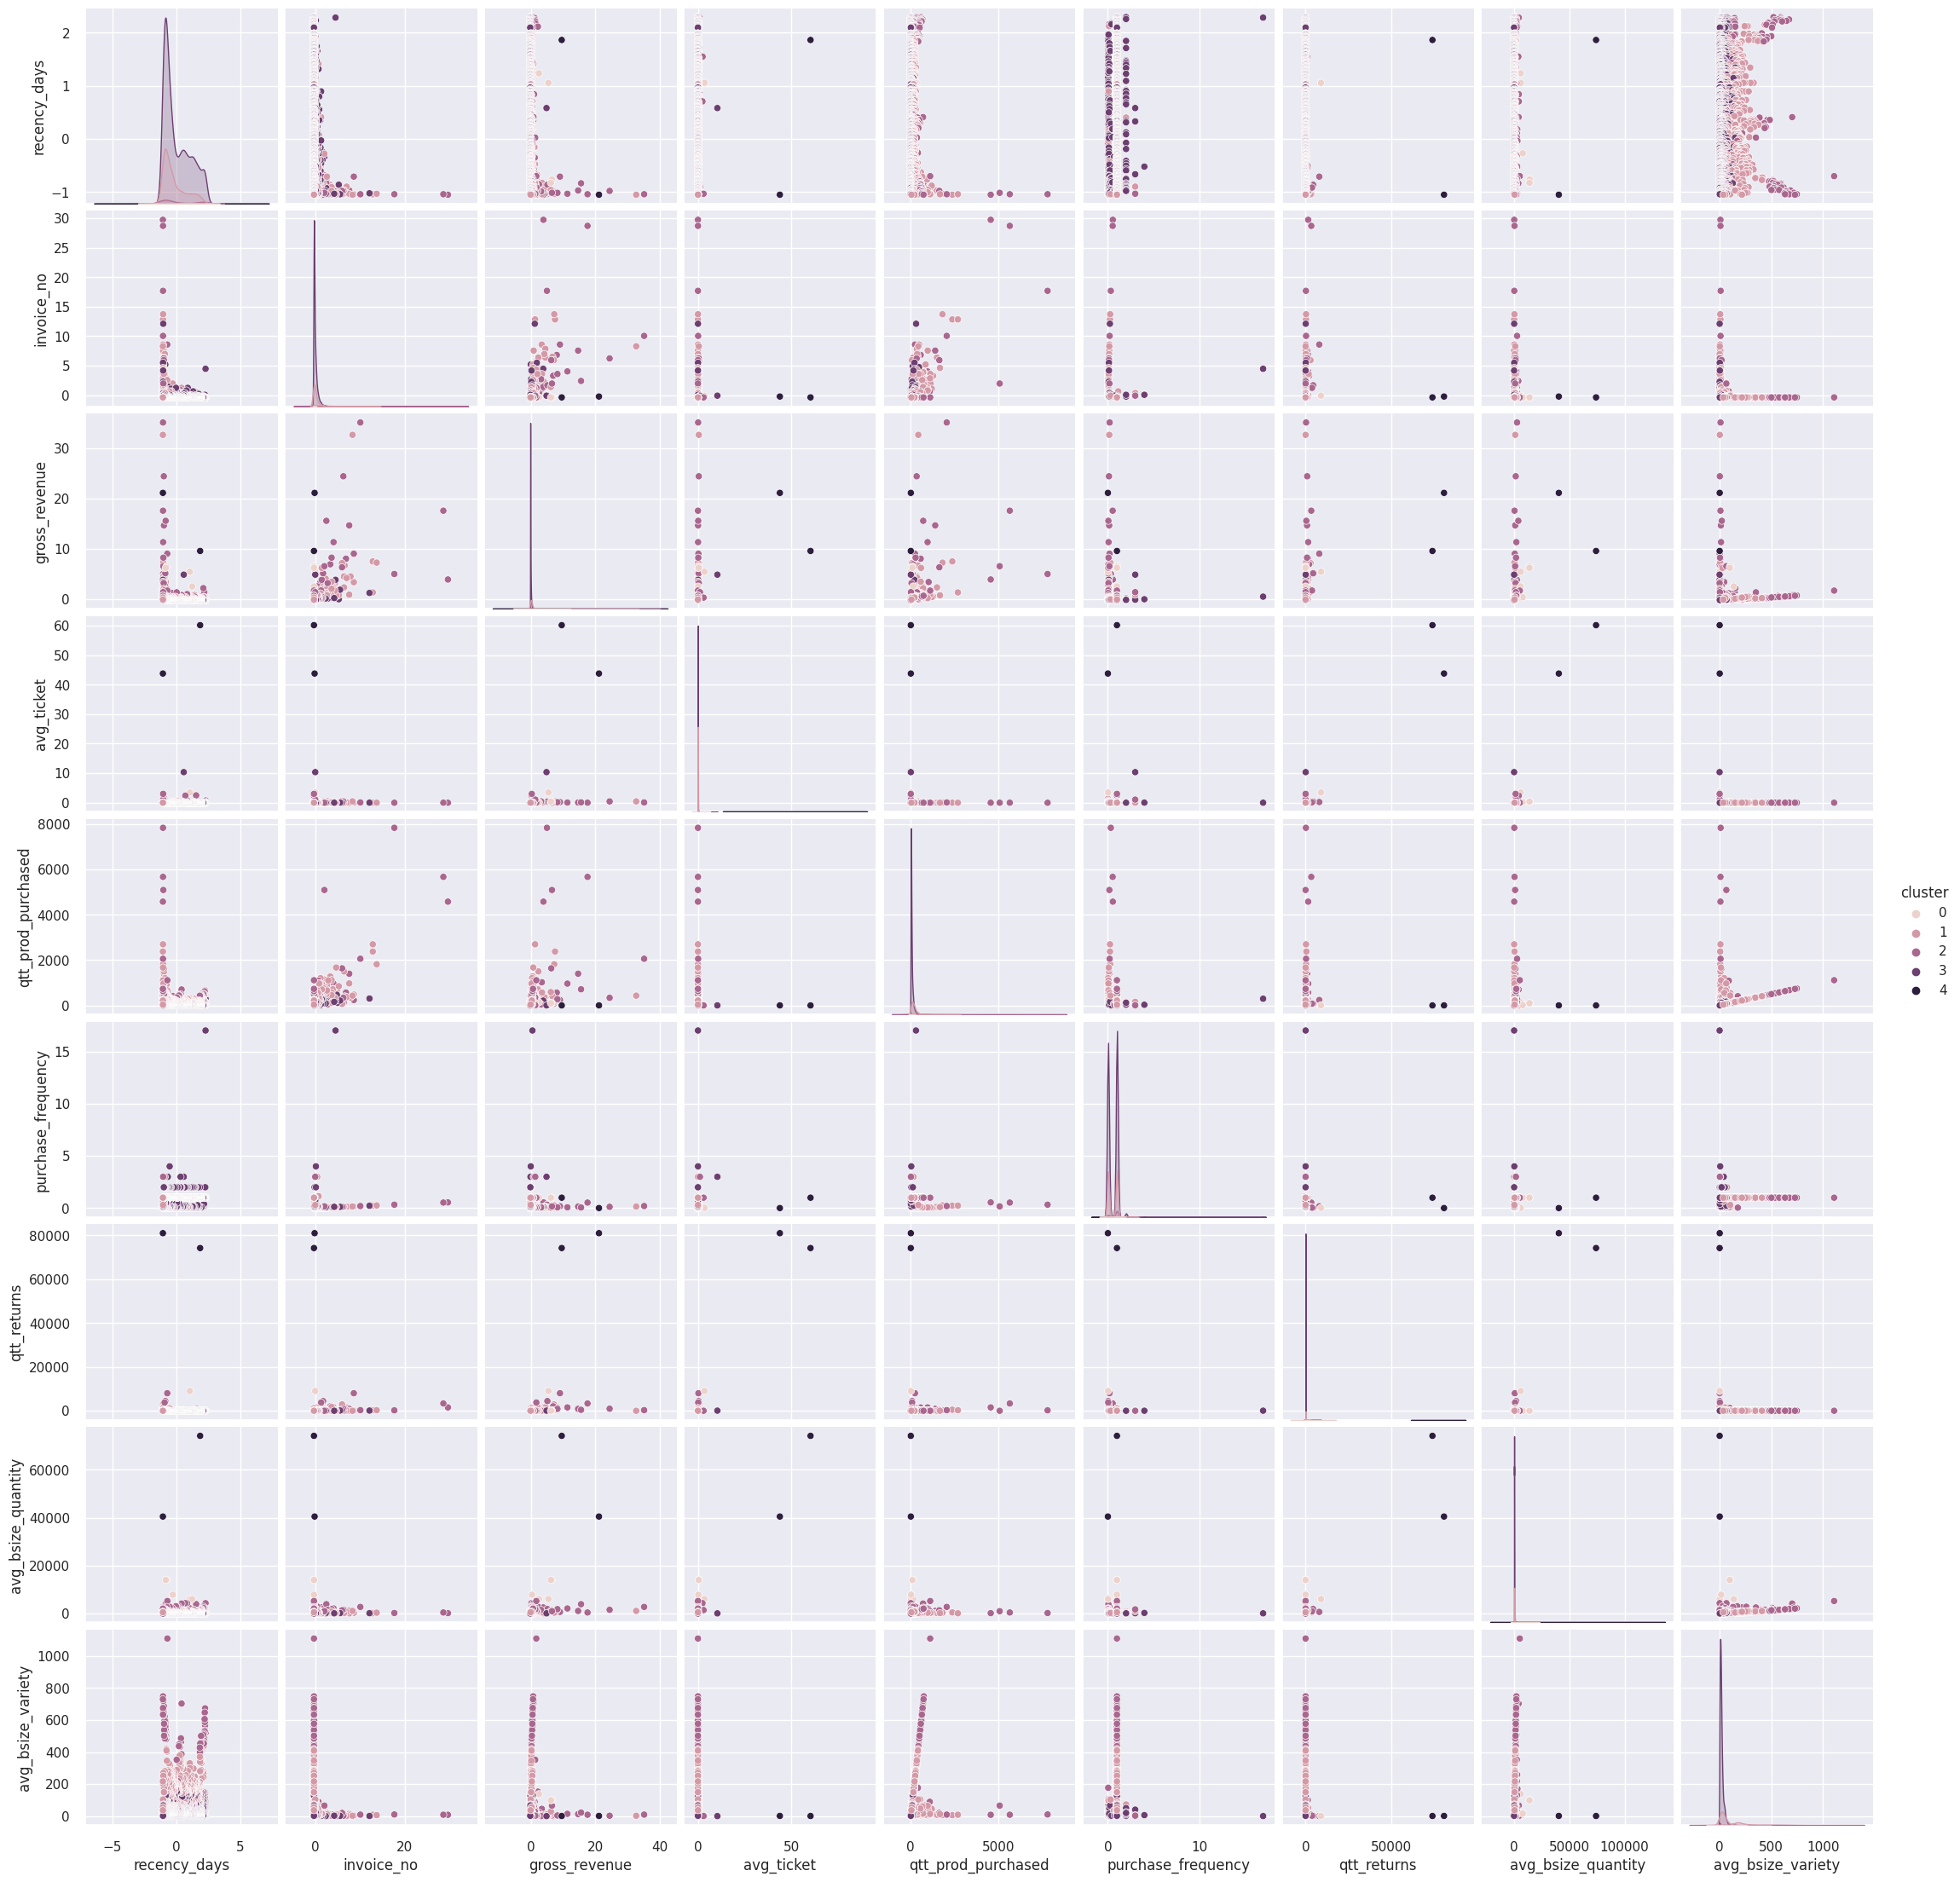

In [51]:
df_viz = df9.drop( 'customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster');

## 9.3 UMAP

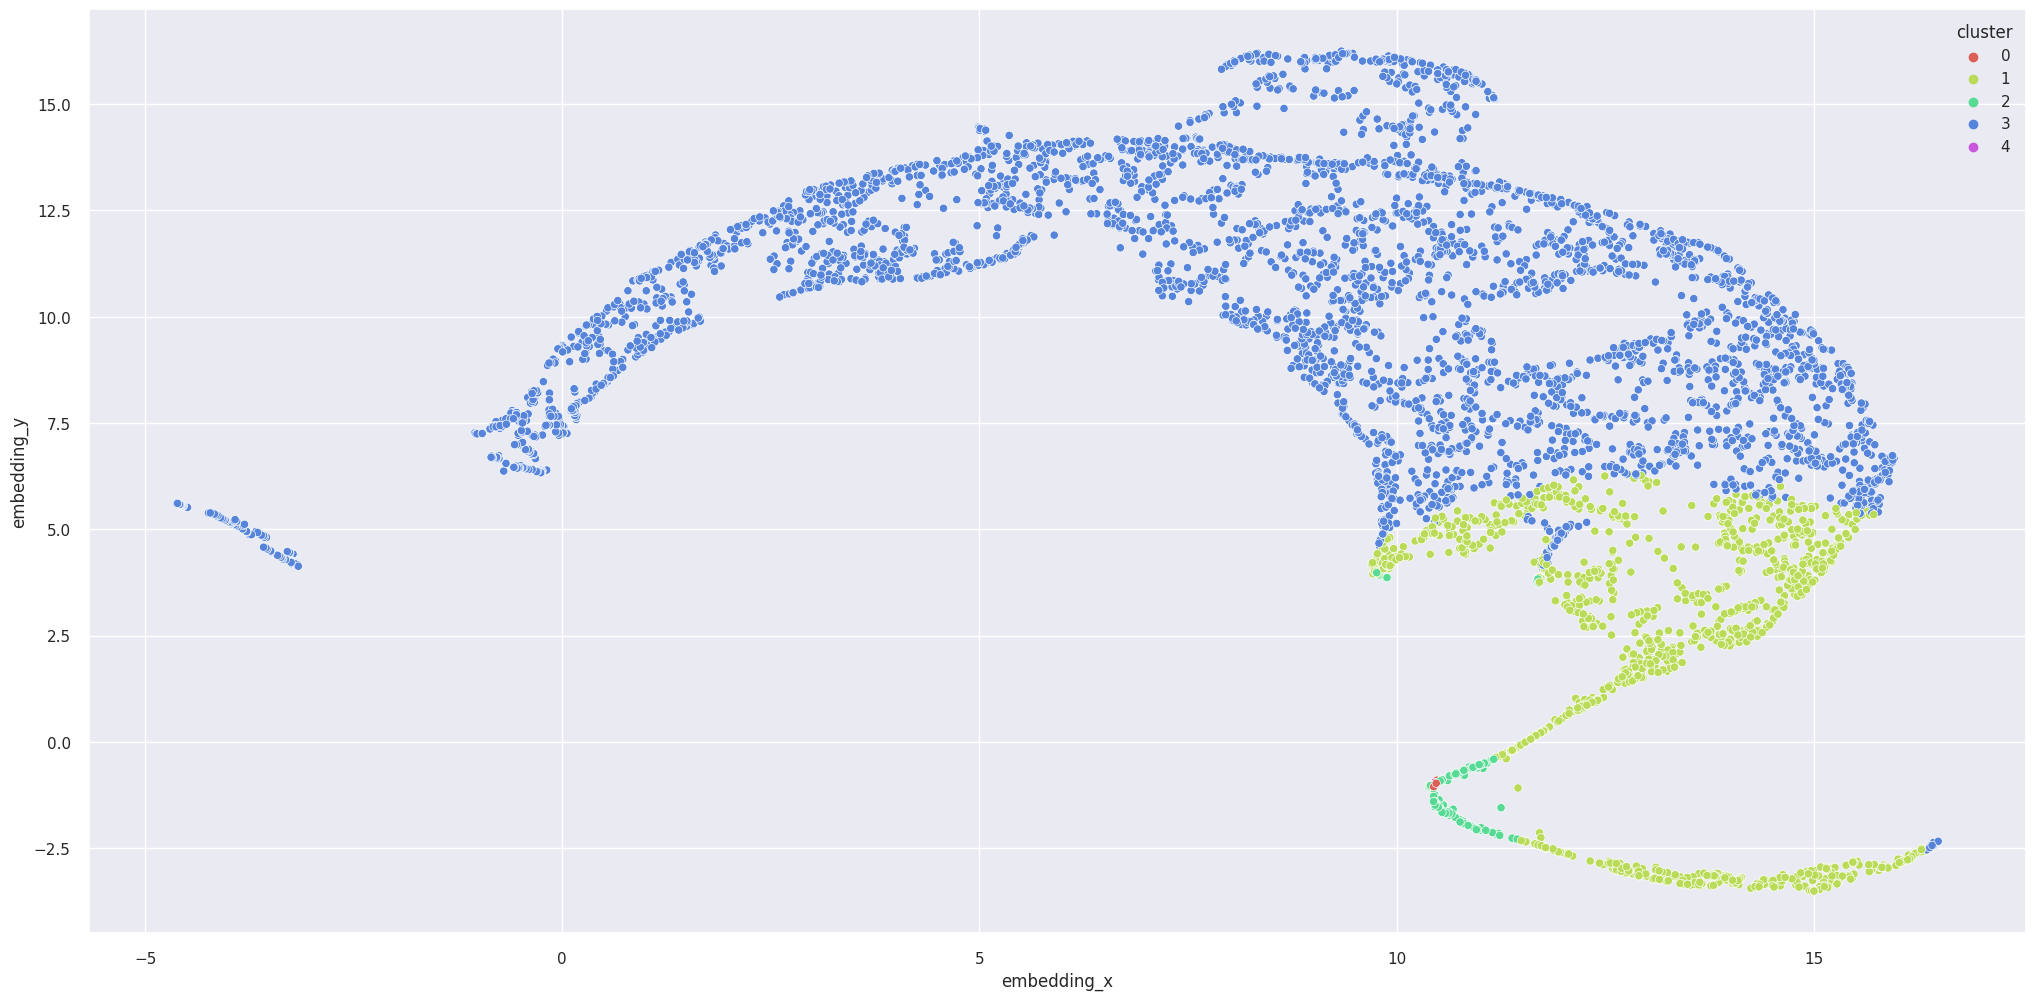

In [52]:
# pip install umap-learn

reducer = umap.UMAP( n_neighbors=50, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz );

## 9.4 Cluster Profile

In [53]:
# Number of customer
df_cluster = df9[['cluster', 'customer_id']].groupby( 'cluster').count().reset_index().rename( columns = { 'customer_id' : 'count' } )
df_cluster['perc_customer'] = round( df_cluster['count'] / df_cluster['count'].sum() * 100, 2)

# Average Recency Days
df_cluster_recency = df9[['cluster', 'recency_days']].groupby( 'cluster').mean().reset_index()
df_cluster_recency['recency_days'] = round( df_cluster_recency['recency_days'], 2)

# Average Purchase Frequeccy
df_cluster_frequency = df9[['cluster', 'invoice_no']].groupby( 'cluster').mean().reset_index()
df_cluster_frequency['invoice_no'] = round( df_cluster_frequency['invoice_no'], 2)

# Average Gross Revenue
df_cluster_monetary = df9[['cluster', 'gross_revenue']].groupby( 'cluster').mean().reset_index()
df_cluster_monetary['gross_revenue'] = round( df_cluster_monetary['gross_revenue'], 2)

# Average Ticket
df_cluster_ticket = df9[['cluster', 'avg_ticket']].groupby( 'cluster').mean().reset_index()
df_cluster_ticket['avg_ticket'] = round( df_cluster_ticket['avg_ticket'], 2)

# Merging datasets
df_cluster = pd.merge( df_cluster, df_cluster_recency,   how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_frequency, how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_monetary,  how='inner', on='cluster' )
df_cluster = pd.merge( df_cluster, df_cluster_ticket,    how='inner', on='cluster' )
df_cluster.head()


,cluster,count,perc_customer,recency_days,invoice_no,gross_revenue,avg_ticket
0,0,5,0.09,0.09,-0.30,4.17,0.88
1,1,1218,21.38,-0.19,0.19,0.21,-0.02
2,2,141,2.48,0.14,0.78,1.73,0.08
3,3,4330,76.02,0.05,-0.08,-0.13,-0.02
4,4,2,0.04,0.41,-0.29,15.33,51.99
